In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

I used the retail data analytics to test a simple auto regressive (AR) model to forecast the sales volume using sales only and sales + external information. While the data might be used to draw many insights on this retail business, here I focus only on implementing the AR model to forecast the sales volume.

# Import the data

In [5]:
#import zipfile
#zip_file = zipfile.ZipFile('retail-data-analytics.zip', 'r')
#zip_file.namelist()

FileNotFoundError: [Errno 2] No such file or directory: 'retail-data-analytics.zip'

In [7]:
features=pd.read_csv('Features data set.csv')
sales=pd.read_csv('sales data-set.csv')
stores=pd.read_csv('stores data-set.csv')

In [8]:
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

In [9]:
print(features.shape)
print(sales.shape)
print(stores.shape)

print(sales[0:1].Date, sales[-1:].Date)

print(features[0:1].Date, features[-1:].Date)

(8190, 12)
(421570, 5)
(45, 3)
0   2010-05-02
Name: Date, dtype: datetime64[ns] 421569   2012-10-26
Name: Date, dtype: datetime64[ns]
0   2010-05-02
Name: Date, dtype: datetime64[ns] 8189   2013-07-26
Name: Date, dtype: datetime64[ns]


# Merge the data in a unique DataFrame

In [10]:
df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df=pd.merge(df,stores, on=['Store'], how='left')

df=df.fillna(0)
df['Temperature'] = (df['Temperature']- 32) * 5./9.

types_encoded, types =df['Type'].factorize()
df['Type'] = types_encoded

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315
1,1,1,2010-12-02,46039.49,True,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,151315
2,1,1,2010-02-19,41595.55,False,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,151315
3,1,1,2010-02-26,19403.54,False,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,151315
4,1,1,2010-05-03,21827.90,False,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,151315


# Check data and features

In [11]:
print('training_data duplicated:{}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace=True)

training_data duplicated:0


In [12]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,15.605588,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,0.589912,136727.915739
std,12.785297,30.492054,22711.183519,10.248851,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328
min,1.000000,1.000000,-4988.940000,-18.922222,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,0.000000,34875.000000
25%,11.000000,18.000000,2079.650000,8.155556,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,0.000000,93638.000000
50%,22.000000,37.000000,7612.030000,16.716667,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,0.000000,140167.000000
75%,33.000000,74.000000,20205.852500,23.488889,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,1.000000,202505.000000
max,45.000000,99.000000,693099.360000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2.000000,219622.000000


In [13]:
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
column Type,int64,int64,datetime64[ns],float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Gain some graphical insight

Plot some of the variable present in the data frame such as temperature, fuel price, CPI, unemployment rate, ...

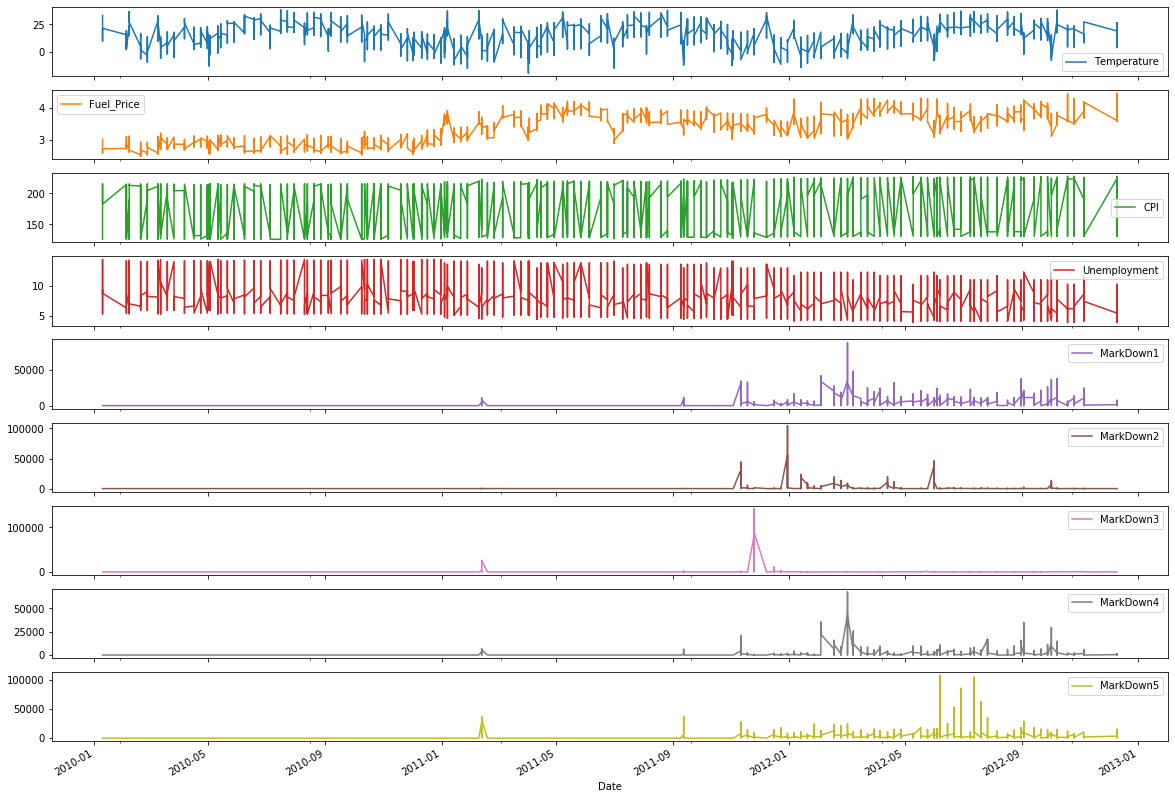

In [15]:
df[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))
plt.show()

Sum the weekely sales from every shop to get the total weekly sales volume of the retail chain

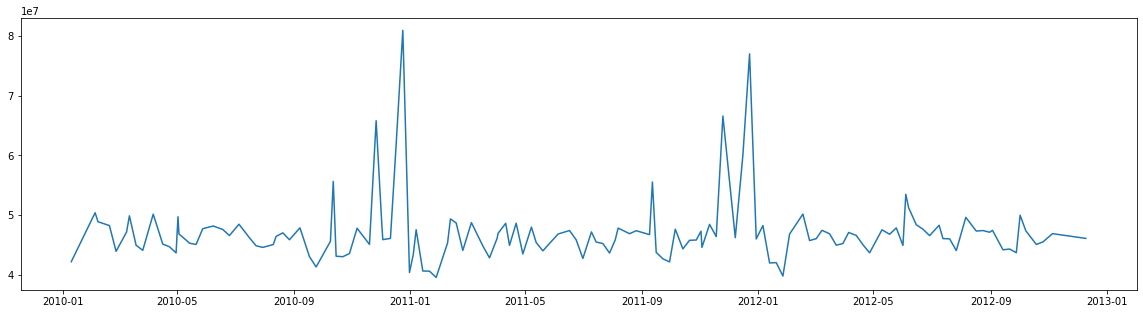

In [16]:
df_average_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
plt.show()

# Get more insights

In [17]:
# The more remunerative weeks
df_average_sales.head()

,Date,Weekly_Sales
46,2010-12-24,80931415.60
98,2011-12-23,76998241.31
95,2011-11-25,66593605.26
41,2010-11-26,65821003.24
45,2010-12-17,61820799.85


In [18]:
# The least remunerative weeks
df_average_sales[::-1].head()

,Date,Weekly_Sales
52,2011-01-28,39599852.99
103,2012-01-27,39834974.67
47,2010-12-31,40432519.00
51,2011-01-21,40654648.03
50,2011-01-14,40673678.04


In [14]:
# The least remunerative weeks
df_average_sales[::-1].head()

,Date,Weekly_Sales
52,2011-01-28,39599852.99
103,2012-01-27,39834974.67
47,2010-12-31,40432519.00
51,2011-01-21,40654648.03
50,2011-01-14,40673678.04


In [19]:
ts = df_average_sales_week.set_index('Date')
#ts = ts.resample('H').ffill()
#ts = ts.resample('W').sum()

In [20]:
# The least remunerative weeks
df_average_sales[::-1].head()

,Date,Weekly_Sales
52,2011-01-28,39599852.99
103,2012-01-27,39834974.67
47,2010-12-31,40432519.00
51,2011-01-21,40654648.03
50,2011-01-14,40673678.04


In [21]:
# Top performing type of stores in term of sales
df_top_stores = df.groupby(by=['Type'], as_index=False)['Weekly_Sales'].sum()
df_top_stores.sort_values('Weekly_Sales', ascending=False)

,Type,Weekly_Sales
0,0,4.331015e+09
1,1,2.000701e+09
2,2,4.055035e+08


In [18]:
# Top performing stores in term of sales
df_top_stores = df.groupby(by=['Store'], as_index=False)['Weekly_Sales'].sum()
df_top_stores.sort_values('Weekly_Sales', ascending=False)[:3]

,Store,Weekly_Sales
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08


# Forecast of the total sales volume

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


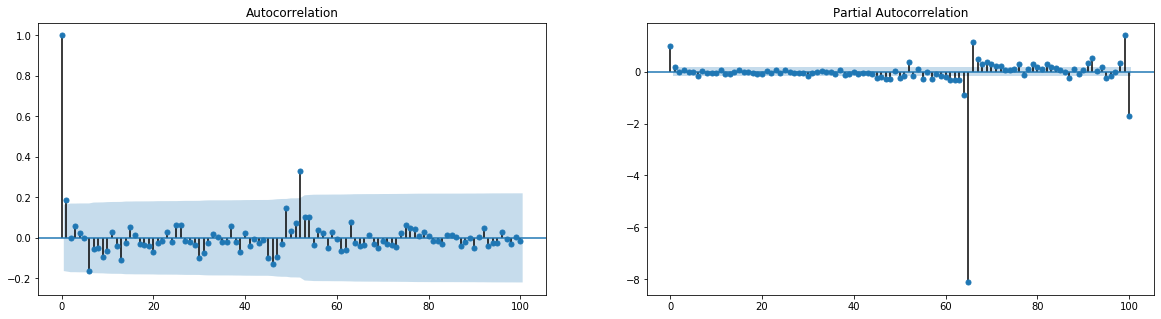

In [22]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(ts, lags=100, ax=axes[0])
plot_pacf(ts, lags=100, ax=axes[1])
plt.show()

# Model definition
Since the AR model implemented in the statsmodels library allows to include only consecutive seasonality terms, I implement the model manually. In this way I can use non consecutive seasonality terms like weeks 1, 6, 52 as observed from the correlation analysis.

In [23]:
from sklearn.linear_model import LinearRegression

def fit_ar_model(ts, orders):
    
    X=np.array([ ts.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(ts))])
    
    mask = ~np.isnan(X[:,:1]).squeeze()
    
    Y= ts.values
    
    lin_reg=LinearRegression()
    
    lin_reg.fit(X[mask],Y[mask])
    
    print(lin_reg.coef_, lin_reg.intercept_)

    print('Score factor: %.2f' % lin_reg.score(X[mask],Y[mask]))
    
    return lin_reg.coef_, lin_reg.intercept_
    
def predict_ar_model(ts, orders, coef, intercept):
    return np.array([np.sum(np.dot(coef, ts.values[(i-orders)].squeeze())) + intercept  if i >= np.max(orders) else np.nan for i in range(len(ts))])

Given the seasonality observed from the ACF and the PACF function, the AR model is implemented including seasonality from weeks (1,6,52).

[[ 0.13488444 -0.06693086  0.53027452]] [19022705.56418592]
Score factor: 0.41


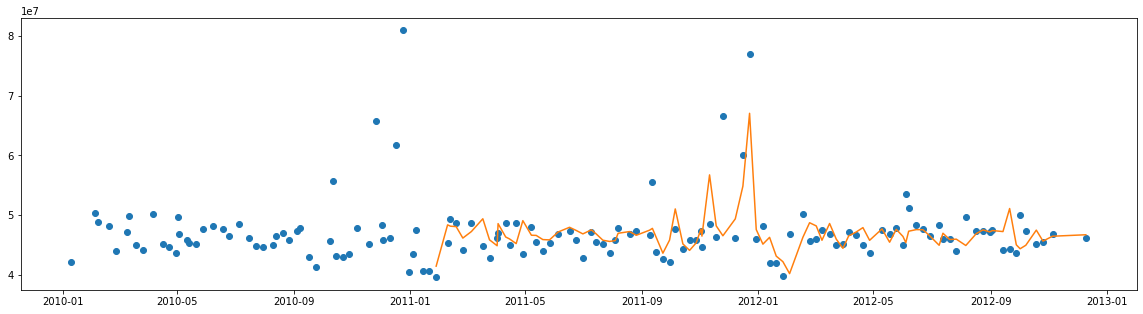

In [24]:
orders=np.array([1,6,52])
coef, intercept = fit_ar_model(ts,orders)
pred=pd.DataFrame(index=ts.index, data=predict_ar_model(ts, orders, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(ts, 'o')
plt.plot(pred)
plt.show()

AR Residuals: avg -0.00, std 0.07


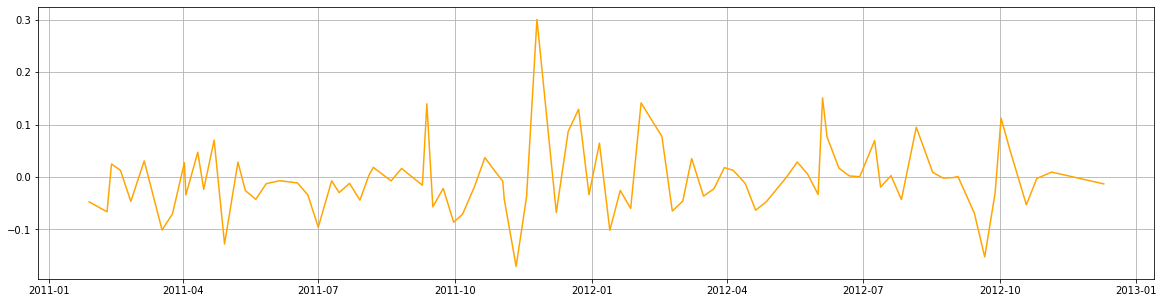

In [25]:
diff=(ts['Weekly_Sales']-pred[0])/ts['Weekly_Sales']

print('AR Residuals: avg %.2f, std %.2f' % (diff.mean(), diff.std()))
 
plt.figure(figsize=(20,5))
plt.plot(diff, c='orange')
plt.grid()
plt.show()

The predictive model has an R^2 score factor of 0.41 (max score for perfect prediction would be 1). The residual distribution is centered in 0 with an STD of 7%.

# Forecast of the store-wise sales volume
Develop the forecast model for the store number 20, which shows the highest sales volume.

In [26]:
df20=df.where( df['Store'] == 20)
df20=df20.dropna()
df20=df20.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df20 = df20.set_index('Date')
df20.head()

,Weekly_Sales
Date,
2010-01-10,1933719.21
2010-02-04,2405395.22
2010-02-07,2143676.77
2010-02-19,2161549.76
2010-02-26,1898193.95


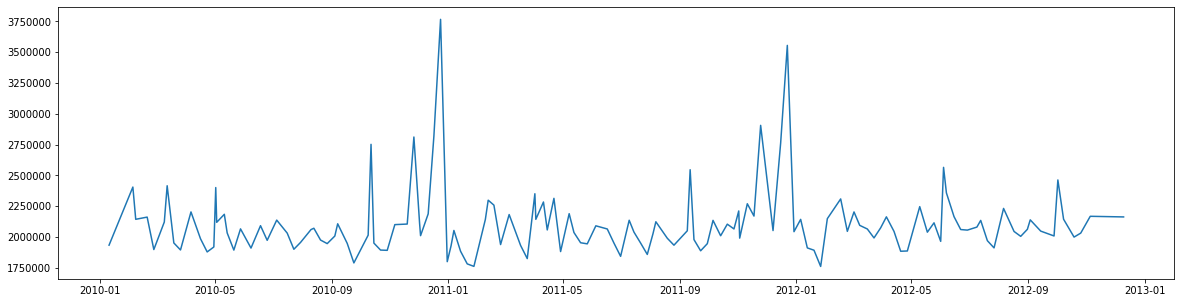

In [27]:
plt.figure(figsize=(20,5))
plt.plot(df20.index, df20.values)
plt.show()

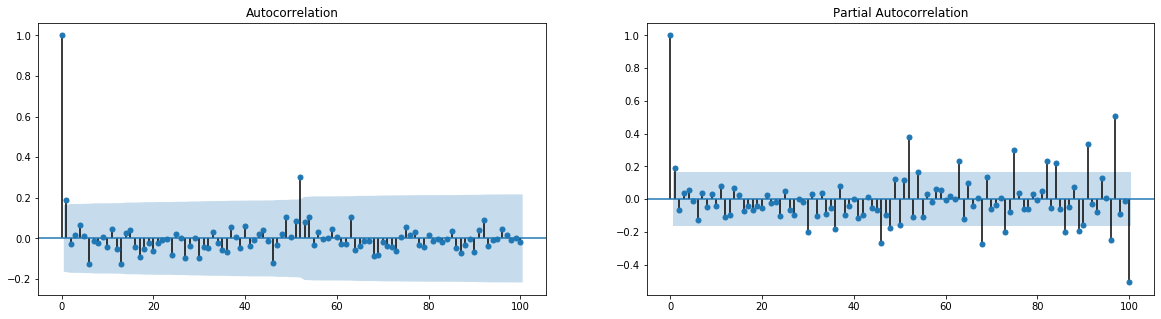

In [28]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(df20.values, lags=100, alpha=0.05, ax=axes[0])
plot_pacf(df20.values, lags=100, alpha=0.05, ax=axes[1])
plt.show()

This particular store shows additional seasonalities from week 29 and 46 which will be included in the AR model.

[[ 0.10930369 -0.05888729  0.04638539 -0.07044943  0.46939893]] [1075563.7365969]
Score factor: 0.34


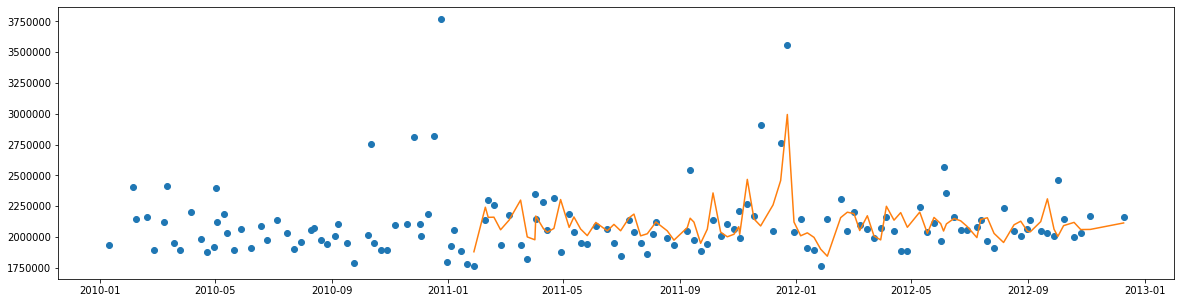

In [29]:
orders=np.array([1,6,29,46,52])
coef, intercept = fit_ar_model(df20,orders)
pred=pd.DataFrame(index=df20.index, data=predict_ar_model(df20, orders, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(df20, 'o')
plt.plot(pred)
plt.show()

AR Residuals: avg -0.01, std 0.08


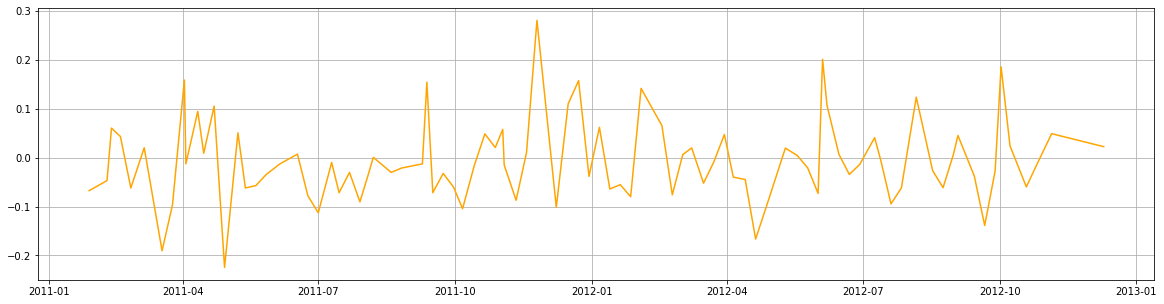

In [30]:
diff=(df20['Weekly_Sales']-pred[0])/df20['Weekly_Sales']

print('AR Residuals: avg %.2f, std %.2f' % (diff.mean(), diff.std()))
 
plt.figure(figsize=(20,5))
plt.plot(diff, c='orange')
plt.grid()
plt.show()

![](http://)The predictive model has an R^2 score factor of 0.34 (max score for perfect prediction would be 1.). The residual distribution is centered in 0 with an STD of 8%.

### Look for predictive power from external variables

In [31]:
dfext=df.where( df['Store'] == 20)
dfext=dfext.dropna()
dfext=dfext.groupby(by=['Date'], as_index=False)[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                                                  'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean()
dfext = dfext.set_index('Date')
dfext.head()

,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,,,,,
2010-01-10,16.155556,2.707,204.885097,7.484,0.0,0.0,0.0,0.0,0.0
2010-02-04,10.555556,2.850,204.025284,7.856,0.0,0.0,0.0,0.0,0.0
2010-02-07,21.166667,2.815,204.465056,7.527,0.0,0.0,0.0,0.0,0.0
2010-02-19,-3.650000,2.745,204.432100,8.187,0.0,0.0,0.0,0.0,0.0
2010-02-26,0.177778,2.754,204.463087,8.187,0.0,0.0,0.0,0.0,0.0


In [32]:
dfext.describe()

,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,13.028555,3.417608,209.038131,7.371413,4013.042867,1815.373007,956.883986,1934.258951,2159.098951
std,9.191026,0.443029,4.176736,0.305069,8231.447936,9402.698654,8733.609037,5799.518501,4293.364349
min,-6.450000,2.699000,203.610178,6.961000,0.000000,-0.990000,0.000000,0.000000,0.000000
25%,6.036111,2.921000,204.774194,7.139000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.805556,3.541000,208.556714,7.287000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.294444,3.809000,213.372861,7.484000,6185.310000,70.000000,17.675000,1325.400000,3484.570000
max,26.222222,4.066000,216.151590,8.187000,58928.520000,97740.990000,101378.790000,53603.990000,35675.620000


In [33]:
dfext['shifted_sales'] = df20.shift(-1)
dfext.head()

,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,shifted_sales
Date,,,,,,,,,,
2010-01-10,16.155556,2.707,204.885097,7.484,0.0,0.0,0.0,0.0,0.0,2405395.22
2010-02-04,10.555556,2.850,204.025284,7.856,0.0,0.0,0.0,0.0,0.0,2143676.77
2010-02-07,21.166667,2.815,204.465056,7.527,0.0,0.0,0.0,0.0,0.0,2161549.76
2010-02-19,-3.650000,2.745,204.432100,8.187,0.0,0.0,0.0,0.0,0.0,1898193.95
2010-02-26,0.177778,2.754,204.463087,8.187,0.0,0.0,0.0,0.0,0.0,2121561.41


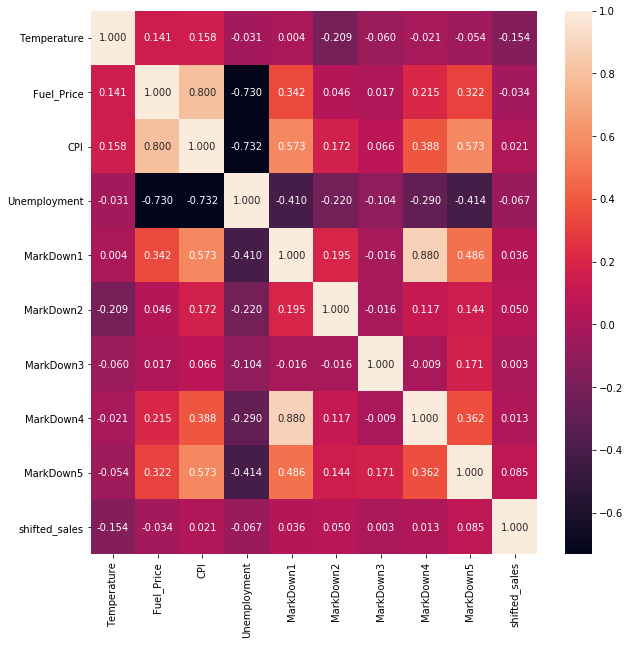

In [34]:
import seaborn as sns
corr = dfext.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
            annot=True, fmt=".3f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [35]:
corr['shifted_sales'].sort_values(ascending=False)

shifted_sales    1.000000
MarkDown5        0.084797
MarkDown2        0.050189
MarkDown1        0.035654
CPI              0.021002
MarkDown4        0.013042
MarkDown3        0.002624
Fuel_Price      -0.033798
Unemployment    -0.067482
Temperature     -0.154182
Name: shifted_sales, dtype: float64

![](http://)The external variables available have some correlation with the 1-day lagged sales time series. This means that they have some degree of predictive power at 1 day and can be used to improve our model. The 'MarkDown' and the 'Temperature' being the most correlated and anti-correlate variables respectively.

In [36]:
def fit_ar_model_ext(ts, orders, ext, fitter=LinearRegression()):
    
    X=np.array([ ts.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(ts))])
    
    X = np.append(X, ext.values, axis=1)
    
    mask = ~np.isnan(X[:,:1]).squeeze()
    
    Y= ts.values
    
    fitter.fit(X[mask],Y[mask].ravel())
    
    print(fitter.coef_, fitter.intercept_)

    print('Score factor: %.2f' % fitter.score(X[mask],Y[mask]))
    
    return fitter.coef_, fitter.intercept_
    
def predict_ar_model_ext(ts, orders, ext, coef, intercept):

    X=np.array([ ts.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(ts))])
    
    X = np.append(X, ext.values, axis=1)
    
    return np.array( np.dot(X, coef.T) + intercept)

[ 1.72193363e-01 -1.00712307e-01  5.02007961e-02 -5.40426670e-02
  4.34603507e-01 -2.68876289e+05 -1.90225365e+05  1.39737992e+04
 -3.79874695e+03 -2.14311958e+00 -4.31045916e+00  7.04969510e+00
  4.85327292e+00 -3.12871978e+00] 807984.7912208033
Score factor: 0.58


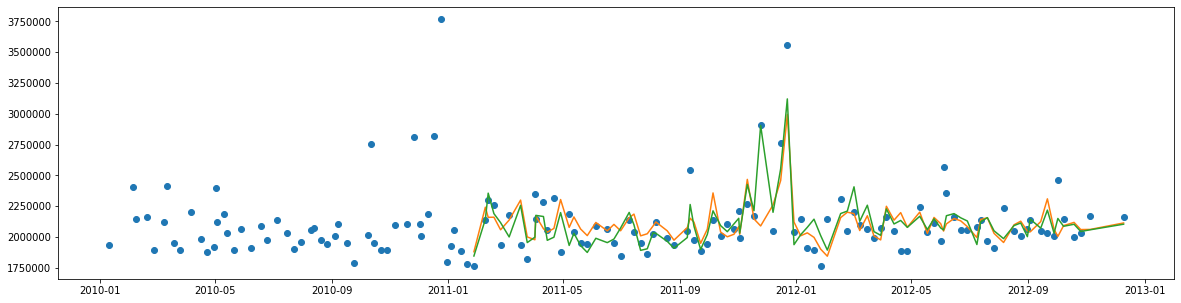

In [37]:
#dfexte=dfext.drop(['shifted_sales'], axis=1)
dfexte=dfext[['Unemployment','Fuel_Price','CPI','Temperature',
              'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]

orders=np.array([1,6,29,46,52])
coef, intercept = fit_ar_model_ext(df20,orders,dfexte)
pred_ext=pd.DataFrame(index=df20.index, data=predict_ar_model_ext(df20, orders, dfexte, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(df20, 'o')
plt.plot(pred)
plt.plot(pred_ext)
plt.show()

AR Residuals: avg -0.01, std 0.08
AR wiht Ext Residuals: avg -0.00, std 0.07


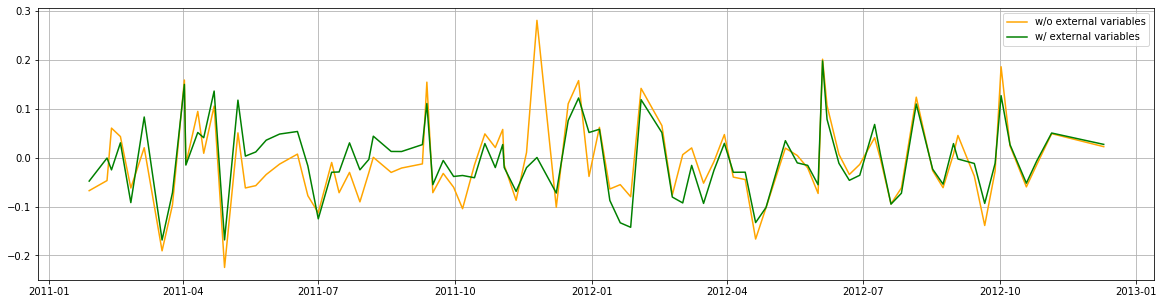

In [38]:
diff=(df20['Weekly_Sales']-pred[0])/df20['Weekly_Sales']
diff_ext=(df20['Weekly_Sales']-pred_ext[0])/df20['Weekly_Sales']

print('AR Residuals: avg %.2f, std %.2f' % (diff.mean(), diff.std()))
print('AR wiht Ext Residuals: avg %.2f, std %.2f' % (diff_ext.mean(), diff_ext.std()))
 
plt.figure(figsize=(20,5))
plt.plot(diff, c='orange', label='w/o external variables')
plt.plot(diff_ext, c='green', label='w/ external variables')
plt.legend()
plt.grid()
plt.show()

The model including the external variables improve the accuracy of the prediction by more than 40% ( R^2 score: 0.58 w.r.t 0.34). The standard deviation of the residual improve by about 30% (7% w.r.t. 8%).

# To do next:

* Apply the forecast model with external informations on each store and sum the result to forcast the total sales volume